<a href="https://colab.research.google.com/github/SahilCarterr/Convolution-Neural-Network-Basic-Models/blob/Updates/Food101/02_Model_1_Tiny_Vgg_with_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the Data

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [2]:
#Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 9. Model 1 : TinyVGG with Data Augmentation

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets

### 9.1 Create tranforms with data augmentation

In [4]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's

In [5]:
# turn image folder import Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)
train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [6]:
class_names = train_data_augmented.classes
class_names

['pizza', 'steak', 'sushi']

In [7]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x78447ae0da20>,
 <torch.utils.data.dataloader.DataLoader at 0x78447ae0d990>)

### 9.3 Contruct and Train Model 1

In [8]:
torch.manual_seed(42)
device="cuda" if torch.cuda.is_available()  else "cpu"
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int)->None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
              ),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
              ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2=nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
              ),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
              ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier=nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*16*16,
                out_features=output_shape)
    )
  def forward(self, x:torch.Tensor):
    x=self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.classifier(x)
    return x
model_1=TinyVGG(input_shape=3, hidden_units=10,
                output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [9]:
torch.manual_seed(42)
model_1 = TinyVGG(
  input_shape=3,
  hidden_units=10,
  output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer,
               loss_fn:torch.nn.Module):
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred=model(X)
    loss=loss_fn(y_pred, y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc+=((y_pred_class==y).sum().item()/len(y_pred))
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

In [11]:
def test_step(model:torch.nn.Module,
              loss_fn:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader):
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y =X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [12]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }


    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS =5
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_1_results=train(model = model_1,
                      train_dataloader = train_dataloader_augmented,
                      test_dataloader = test_dataloader_simple,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total Training Time : {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1293 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1479 | test_acc: 0.2604
Total Training Time : 14.794 seconds


### 9.4 Plot the loss curves of Model_1

In [14]:
import matplotlib.pyplot as plt
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):

    loss = results['train_loss']
    test_loss = results['test_loss']


    accuracy = results['train_acc']
    test_accuracy = results['test_acc']


    epochs = range(len(results['train_loss']))


    plt.figure(figsize=(15, 7))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

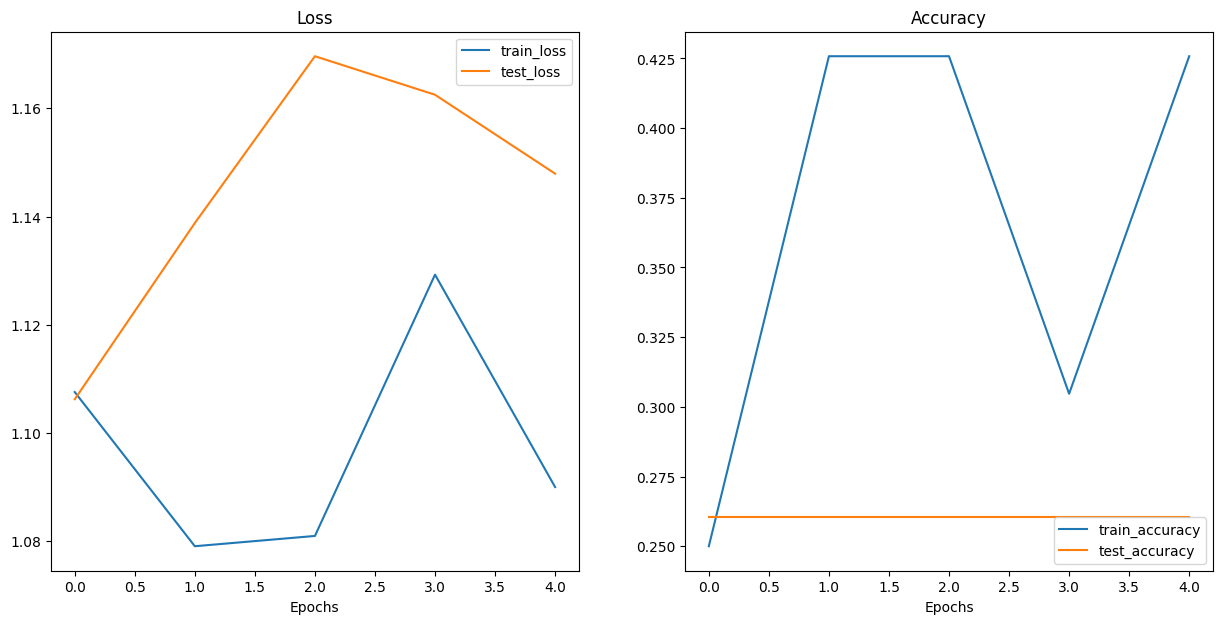

In [15]:
plot_loss_curves(model_1_results)

## 10 Compare model results

In [16]:
model_0_results = {
    'train_loss': [1.107833, 1.084713, 1.115697, 1.095564, 1.098520],
    'train_acc': [0.257812, 0.425781, 0.292969, 0.414062, 0.292969],
    'test_loss': [1.136041, 1.162014, 1.169704, 1.138373, 1.142631],
    'test_acc': [0.260417, 0.197917, 0.197917, 0.197917, 0.197917]
}

In [17]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df= pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.107564,0.250000,1.106237,0.260417
1,1.079070,0.425781,1.138800,0.260417
2,1.080970,0.425781,1.169636,0.260417
3,1.129261,0.304688,1.162515,0.260417
4,1.090008,0.425781,1.147927,0.260417


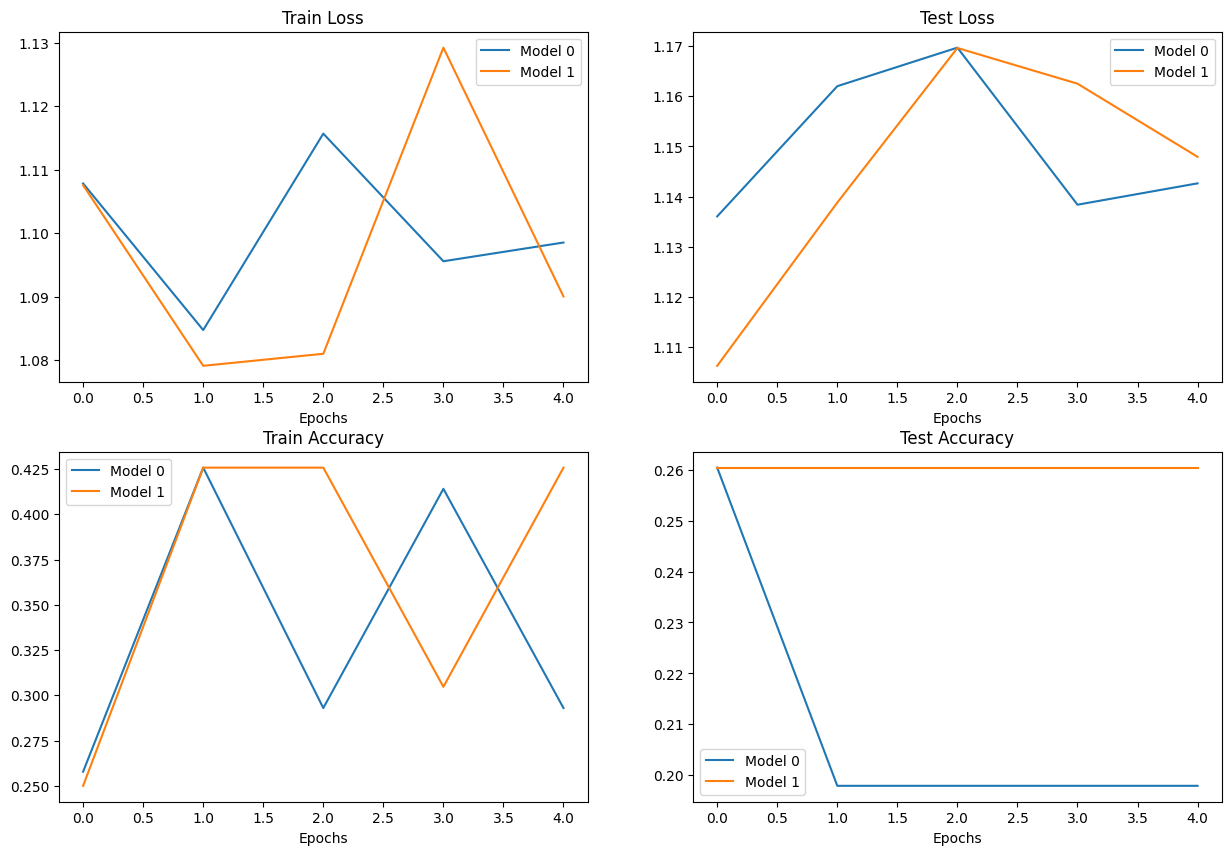

In [18]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make prediction on custom image

In [19]:
# Download custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"


if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in custom image with PyTorch

In [20]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom Image tensor: \n {custom_image_uint8}")
print(f"Custom Image shape: {custom_image_uint8.shape}\n")
print(f"Custom Image dtype: {custom_image_uint8.dtype}")

Custom Image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom Image shape: torch.Size([3, 4032, 3024])

Custom Image dt

In [21]:
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image/255
print(f"Custom Image tensor: \n {custom_image}")
print(f"Custom Image shape: {custom_image.shape}\n")
print(f"Custom Image dtype: {custom_image.dtype}")

Custom Image tensor: 
 tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  

### 11.2 Predicting on custom image with a trained PyTorch Model

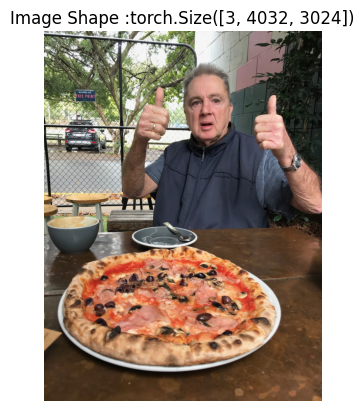

In [22]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.title(f"Image Shape :{custom_image.shape}")
plt.axis(False);

In [23]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])
custom_image_transformed = custom_image_transform(custom_image)
print(f"Original shape:{custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape:torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [24]:
model_1.eval()
with torch.inference_mode():
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [25]:
custom_image_pred

tensor([[ 0.1187,  0.0339, -0.1484]], device='cuda:0')

In [26]:
print(f"Prediction logits : {custom_image_pred}")
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilitties ; {custom_image_pred_probs}")
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits : tensor([[ 0.1187,  0.0339, -0.1484]], device='cuda:0')
Prediction probabilitties ; tensor([[0.3725, 0.3422, 0.2852]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [27]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

In [28]:
custom_image_pred_probs

tensor([[0.3725, 0.3422, 0.2852]], device='cuda:0')

In [29]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image/255
  if transform:
    target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
      target_image = target_image.unsqueeze(dim=0)
      target_image_pred = model(target_image.to(device))
      target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
      target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
      plt.imshow(target_image.squeeze().permute(1, 2, 0))
      if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob:{target_image_pred_probs.max().cpu():.3f}"
      else:
        title = f"Pred; {target_image_pred_label} | Prob {target_image_pred_probs.max().cpu():.3f}"
      plt.title(False)
      plt.axis(False)

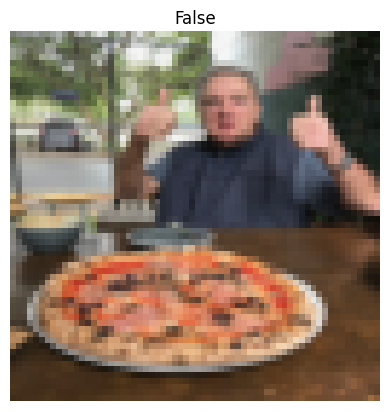

In [30]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)